# MAP654I - Practical introduction to Machine Learning

## Practical Session 2 - Regression

---

In [1]:
import numpy as np
import pylab as pl
import scipy as sp

---

### 1 - Data visualization and pre-processing

In [2]:
ECoG_dataset = np.load('ECoG.npz')

In [3]:
for i in ECoG_dataset:
    print(i, ECoG_dataset[i].shape)

Yall (3327, 1)
Fe (1, 1)
Xall (3327, 64)


Xall is composed of 64 columns that correspond to the different sensors placed on the patient's head. The 3327 lines correspond to the time of the measurements.
Yall is the bending angle of the finger (measured with a glove full of sensors).

In [4]:
Xall = ECoG_dataset['Xall']
Yall = ECoG_dataset['Yall']
Fe   = ECoG_dataset['Fe']

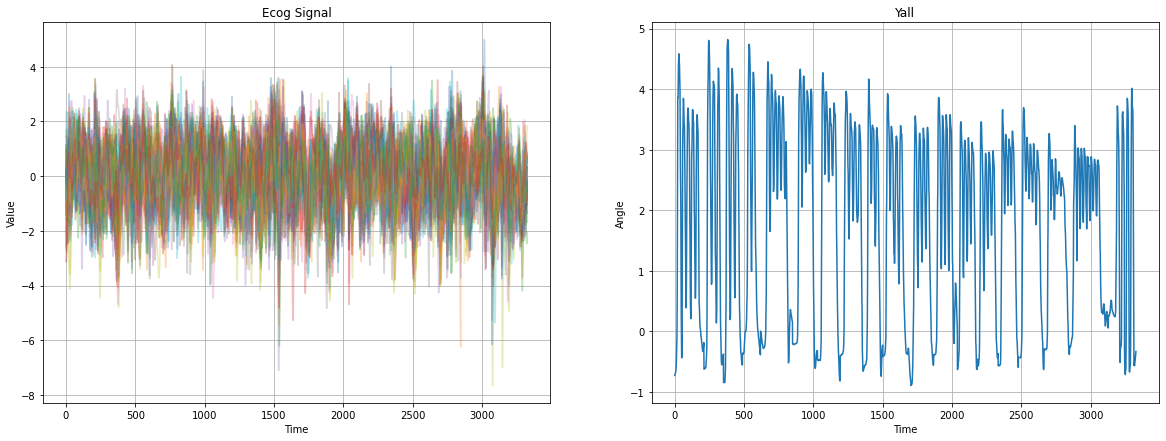

In [5]:
fig, axis = pl.subplots(1,2, figsize=(20,7))
axis[0].plot(Xall, alpha = 0.3)
axis[0].grid()
axis[0].set_title('Ecog Signal')
axis[0].set_xlabel('Time')
axis[0].set_ylabel('Value')

axis[1].plot(Yall)
axis[1].set_title('Yall')
axis[1].set_xlabel('Time')
axis[1].set_ylabel('Angle')
axis[1].grid()

- 64 signals are represented on the first graph. They look already normalized. These are electrical signals from the brain. 
- The other graph shows the bending angle of the finger over time. According to the graph, the subject must have bent his finger several times and regularly over time. The low values of the angle correspond to the bent finger. The higher values show more noise which should correspond to the tremors when the subject leaves his finger stretched.

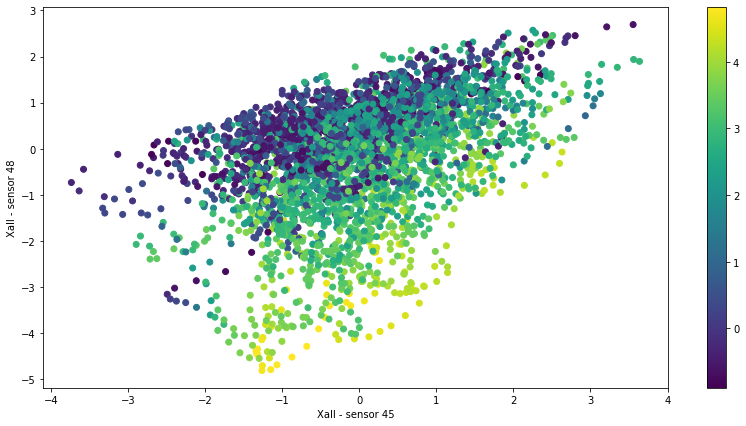

In [6]:
pl.figure(figsize=(14,7))
pl.scatter(Xall[:,45], Xall[:,48], c=Yall)
pl.xlabel('Xall - sensor 45')
pl.ylabel('Xall - sensor 48')
pl.colorbar()

This graph corresponds to the values of sensor 45 compared to those of sensor 48. The colors correspond to the flexion of the finger. This graph is very interesting because we can clearly see that the measurements of sensors 45 and 48 are related to the flexion of the finger. For example, the lower the values of the sensor 48, the more the color is yellow, which corresponds to a large flexion angle of the finger. 

We will try to verify this hypothesis by first applying linear regression on our dataset: 

In [7]:
n = 1000

x_train, y_train = Xall[:n,:], Yall[:n]
x_test, y_test = Xall[n:,:], Yall[n:]

In [8]:
print(x_train.shape)
print(y_train.shape)

(1000, 64)
(1000, 1)


In [9]:
print(x_test.shape)
print(y_test.shape)

(2327, 64)
(2327, 1)


We split the data into test and train set.

---

### 2 - Least Squares regression (LS)

$ \tilde{X}^{T}y = \tilde{X}^{T}\tilde{X}\hat{\theta}$

We create the $ \tilde{X} $ vector:

In [10]:
X_tild = np.concatenate((x_train, np.ones((x_train.shape[0],1))), axis=1)

In [11]:
X_tild.shape

(1000, 65)

Then we use the linalg.solve function from numpy to solve a linear matrix equation:

https://numpy.org/doc/stable/reference/generated/numpy.linalg.solve.html

In [12]:
a=np.dot(X_tild.T, X_tild)
b=np.dot(X_tild.T, y_train)
w = np.linalg.solve(a,b)[:-1]
b = np.linalg.solve(a,b)[-1]

We have the weigth matrix:

In [13]:
w.shape

(64, 1)

and the y-intercept: 

In [14]:
b.shape

(1,)

our final predition is $X.W+b$:

In [15]:
y_train_pred = np.dot(x_train, w) + b

Let's plot the prediction on train set as a function of time:

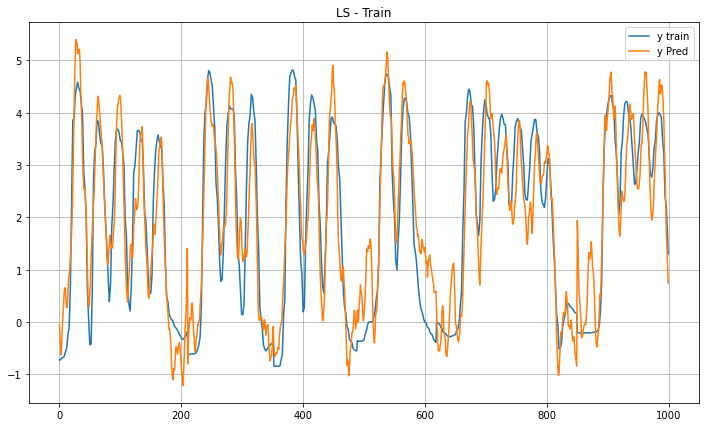

In [16]:
pl.figure(figsize=(12,7))
pl.plot(y_train, label='y train')
pl.plot(y_train_pred, label='y Pred')
pl.title('LS - Train')
pl.legend()
pl.grid()

On train data, the LS algorithm seems to have very good results. The y and y_train curves are almost collapsed.  But we can't judge the algorithm on its ability to recreate the training data. Let's try now with the test data. 

<div class="alert alert-block alert-info">Apply on test data</div>

In [17]:
y_test_pred = np.dot(x_test, w) + b

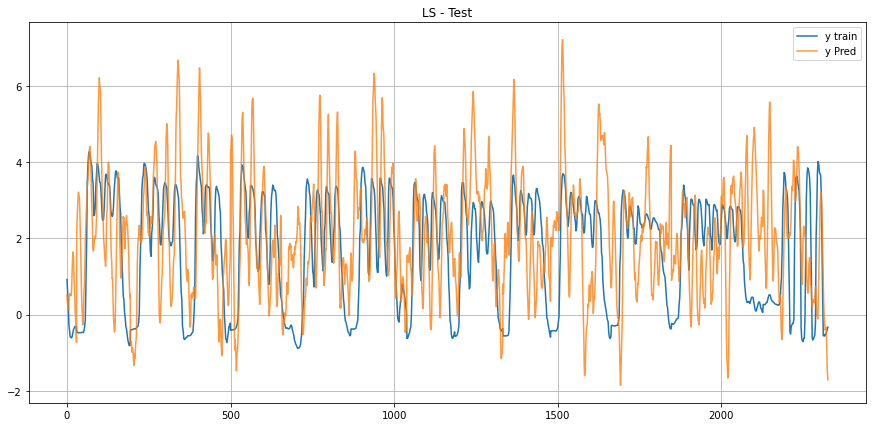

In [18]:
pl.figure(figsize=(15,7))
pl.plot(y_test, label='y train')
pl.plot(y_test_pred, label='y Pred', alpha=0.8)
pl.legend()
pl.title('LS - Test')
pl.grid()

Things get more complicated with test data. The first flexion of the finger seems to be well restored. Afterwards, the algorithm seems to get out of control and no longer corresponds to the real data. Estimating the finger flexion using this algorithm therefore seems to be complicated. 

Let's apply performance measures to our results:

<div class="alert alert-block alert-info">MSE</div>

In [19]:
from sklearn.metrics import mean_squared_error

In [20]:
mse_train_ls = mean_squared_error(y_train, y_train_pred)
mse_train_ls

0.5040654614476062

In [21]:
mse_test_ls = mean_squared_error(y_test, y_test_pred)
mse_test_ls

3.0455368767601736

The error is multiplied by 6 between the input and test data. This is enormous. This can be explained by saying that the LS algorithm does not have regularisation.

<div class="alert alert-block alert-info">$R^2$</div>

In [22]:
from sklearn.metrics import r2_score

In [23]:
r2_train_ls = r2_score(y_train, y_train_pred)
r2_train_ls

0.8395001217500111

In [24]:
r2_test_ls = r2_score(y_test, y_test_pred)
r2_test_ls

-0.4281700630222576

As we said earlier, the R2 score seems to be good on the training data but extremely bad on the test data. It is even negative on the test data, which means that the prediction is worse than a random prediction 

We can now use the LS algorithm implemented by Sklearn to compare with ours:

<div class="alert alert-block alert-info">Sklearn algorithm</div>

In [25]:
from sklearn.linear_model import LinearRegression

In [26]:
reg = LinearRegression().fit(x_train, y_train)

In [27]:
reg.score(x_train, y_train)

0.8395001217500111

In [28]:
reg.score(x_test, y_test)

-0.4281700630222456

We notice that the score directly implemented by SKlearn for the linear regression is the $R^2$, we obtained exactly the same results.

In [29]:
np.allclose(reg.coef_, w.T)

True

In [30]:
np.allclose(reg.intercept_, b)

True

The coefficients found by sklearn are the same as ours. The implementation of SKlearn for linear regression seems to be identical to the one done above.

Let's now use a regression with a regulaization coefficient:

### 3 - Ridge regression

In [31]:
from sklearn.linear_model import Ridge

<div class="alert alert-block alert-info">$\lambda = 1$</div>

In [32]:
ridge = Ridge(alpha=1.0).fit(x_train, y_train)

In [33]:
ridge.score(x_train, y_train)

0.8394646608871272

In [34]:
ridge.score(x_test, y_test)

-0.4086181722391595

If we leave the coefficient equal to 1, The algorithm ridge corresponds to the Least Squares algorithm. The results are the same as above. Let's now try to vary the coefficient.

<div class="alert alert-block alert-info">Test with several lambda values</div>

In [35]:
lambda_values = np.logspace(-3, 5, 100)

In [36]:
obtained_scores_train = []
obtained_scores_test = []
W_ridge = []
for lambda_value in lambda_values:
    clf_test = Ridge(alpha=lambda_value).fit(x_train, y_train)
    obtained_scores_train.append(mean_squared_error(y_train, clf_test.predict(x_train)))
    obtained_scores_test.append(mean_squared_error(y_test, clf_test.predict(x_test)))
    W_ridge.append(clf_test.coef_.ravel())

We run the ridge algorithm many times with different values of lambda. At each time we keep the MSE error in a list for train and test set. 

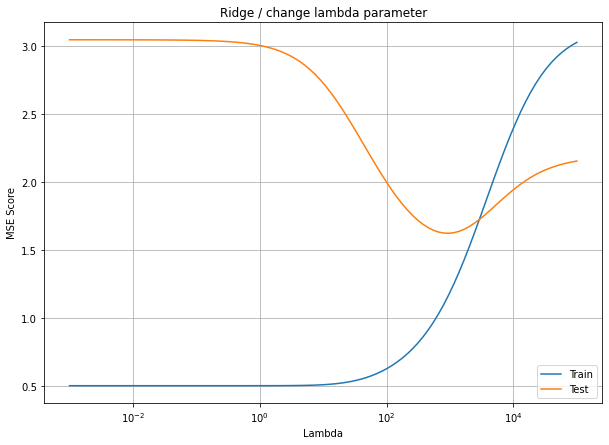

In [37]:
pl.figure(figsize=(10,7))
pl.semilogx(lambda_values,obtained_scores_train, label='Train')
pl.semilogx(lambda_values,obtained_scores_test, label='Test')
pl.ylabel('MSE Score')
pl.xlabel('Lambda')
pl.title('Ridge / change lambda parameter')
pl.grid()
pl.legend()

The parameter has a huge impact on the performance of the algorithm.

The higher Lambda is, the worse the performance of the algorithm on the train data. But what we are most interested in is the performance on the test data. What is interesting is that there is a unique value of the parameter that minimizes the error on the test data. Let's find this value: 

<div class="alert alert-block alert-info">Best value for lambda on test data</div>

In [38]:
best_lambda_ridge = lambda_values[np.array(obtained_scores_test).argmin()]
best_lambda_ridge

954.5484566618347

This value will minimize the error on test set.

<div class="alert alert-block alert-info">Ridge to predict finger flexion</div>

We run the algorithm with the best parameter value:

In [39]:
ridge = Ridge(alpha=best_lambda_ridge).fit(x_train, y_train)

In [40]:
y_train_pred_Ridge = ridge.predict(x_train)

In [41]:
y_test_pred_Ridge = ridge.predict(x_test)

<div class="alert alert-block alert-info">Scatter plot</div>

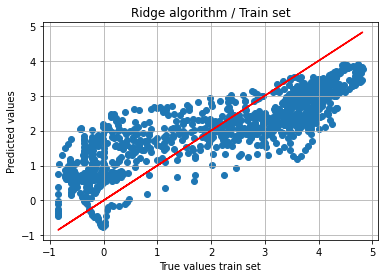

In [42]:
pl.scatter(y_train ,y_train_pred_Ridge)
pl.xlabel('True values train set')
pl.ylabel('Predicted values')
pl.title('Ridge algorithm / Train set')
pl.grid()
pl.plot(y_train, y_train, c='r')

Here we can see a scatter with the true values of the train set along with the predicted values. A perfect regressor would have given us the red curve. Here we are not so far from this red curve. 

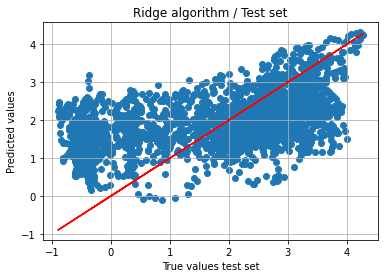

In [43]:
pl.scatter(y_test ,y_test_pred_Ridge)
pl.xlabel('True values test set')
pl.ylabel('Predicted values')
pl.title('Ridge algorithm / Test set')
pl.grid()
pl.plot(y_test,y_test, c='r')

The results are worse with test data, Especially for small sensor values. We will keep this in mind for the analysis of the plots as a function of time.

<div class="alert alert-block alert-info">Plot as a function of time</div>

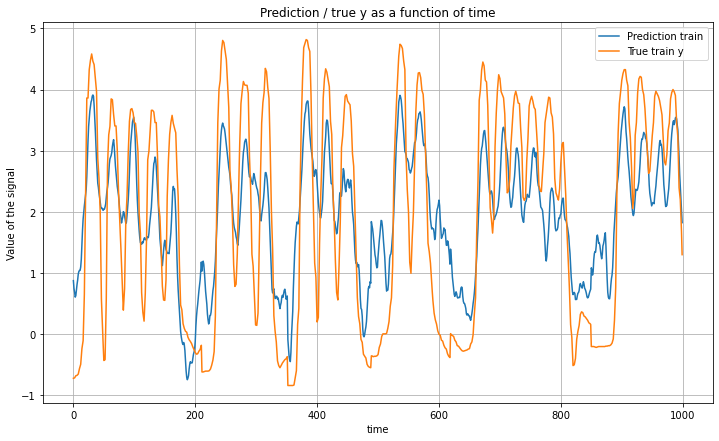

In [44]:
pl.figure(figsize=(12,7))
pl.plot(y_train_pred_Ridge, label='Prediction train')
pl.plot(y_train, label='True train y')
pl.title('Prediction / true y as a function of time')
pl.xlabel('time')
pl.ylabel('Value of the signal')
pl.legend()
pl.grid()

We have changed the value of lambda. This made the algorithm less good on the train data but better on the test data. Here we can notice that the two curves are further apart than for the LS. The shape of the prediction curve is very close to the real shape. But the change of lambda made the prediction curve less stretched.

Let's look at the test data:

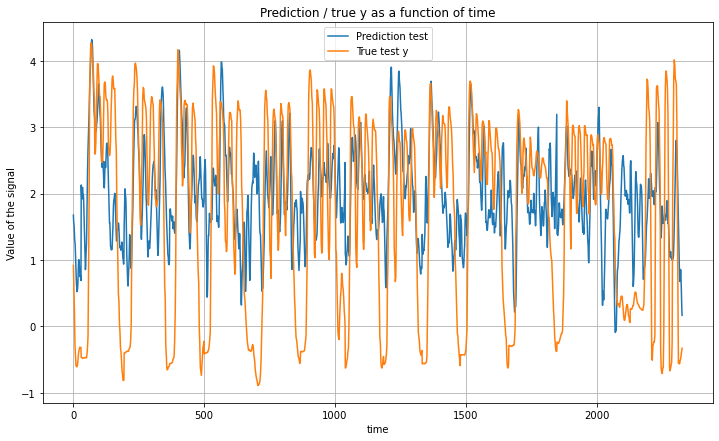

In [45]:
pl.figure(figsize=(12,7))
pl.plot(y_test_pred_Ridge, label='Prediction test')
pl.plot(y_test, label='True test y')
pl.title('Prediction / true y as a function of time')
pl.xlabel('time')
pl.ylabel('Value of the signal')
pl.legend()
pl.grid()

We notice once again that the algorithm may be very good on the train data, but it means nothing on the other data.

The curves are far from being equals. As we noticed earlier on the scatter plot, the smaller the sensor values are, the worse the prediction is.

There are two other things I would like to note:
- The more we advance in time, the worse the predictions of the algorithm are. We could explain this by saying that the brain is complicated to understand, that it evolves over time. We can therefore say that it would be very difficult to predict the evolution of the electrode signals over a long period of time, especially with a linear model. 
- The initial problem was to predict the patient's finger flexion. We are very close to solving the problem with the Ridge algorithm compared to the LS algorithm. Indeed, if we look at the first flexions of the finger, as soon as the prediciton goes under the 1 threshold, we can say that the finger has bent.

<div class="alert alert-block alert-info">MSE</div>

In [46]:
mse_train_ridge = mean_squared_error(y_train, y_train_pred_Ridge)
mse_train_ridge

1.1719430382009632

In [47]:
mse_test_ridge = mean_squared_error(y_test, y_test_pred_Ridge)
mse_test_ridge

1.6239059826952071

<div class="alert alert-block alert-info">$R^2$</div>

In [48]:
r2_train_ridge = r2_score(y_train, y_train_pred_Ridge)
r2_train_ridge

0.6268406996047915

In [49]:
r2_test_ridge = r2_score(y_test, y_test_pred_Ridge)
r2_test_ridge

0.23848766129037868

The results are much better than with the Least Squares algorithm. They are less good on train data but better on test data. 

<div class="alert alert-block alert-info">Comparison with LS estimator</div>

Let's create a dataframe to store all our results:

In [50]:
import pandas as pd
from tabulate import tabulate
 
data = {'Algorithm':["LS", "Ridge"],
        
        'MSE Train': [mse_train_ls, mse_train_ridge],
        'MSE Test':[mse_test_ls, mse_test_ridge],
        
        'R2 Train': [r2_train_ls, r2_train_ridge],
        'R2 Test':[r2_test_ls, r2_test_ridge]
       }
 
df = pd.DataFrame(data)

def print_measures():
    print(tabulate(round(df, 2), headers='keys', tablefmt='pretty',showindex=False))
    
print_measures()

+-----------+-----------+----------+----------+---------+
| Algorithm | MSE Train | MSE Test | R2 Train | R2 Test |
+-----------+-----------+----------+----------+---------+
|    LS     |    0.5    |   3.05   |   0.84   |  -0.43  |
|   Ridge   |   1.17    |   1.62   |   0.63   |  0.24   |
+-----------+-----------+----------+----------+---------+


Thanks to the regularization term, Ridge is less good on train data but much better on test data compared to LS.

<div class="alert alert-block alert-info">Interpret w</div>

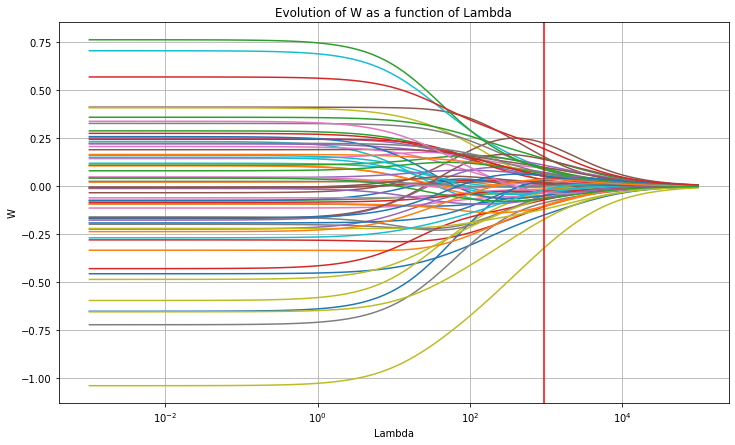

In [51]:
pl.figure(figsize=(12,7))
lambda_values = np.logspace(-3, 5, 100)
fig = pl.semilogx(lambda_values,W_ridge)
pl.axvline(x=best_lambda_ridge,color='r')
pl.title('Evolution of W as a function of Lambda')
pl.xlabel('Lambda')
pl.ylabel('W')
pl.grid()

This graph corresponds to the evolution of the parameters W as a function of lambda. The red line corresponds to the value of lambda that we found best for the test data. 

The higher lambda is, the more the w-weights are crushed and reduced. This makes it possible to regularize the valuers of the weights.

Ridge allows smooth reduction of weight values, which is not the case with Lasso. 

Text(0.5, 1.0, 'abs(w) LS')

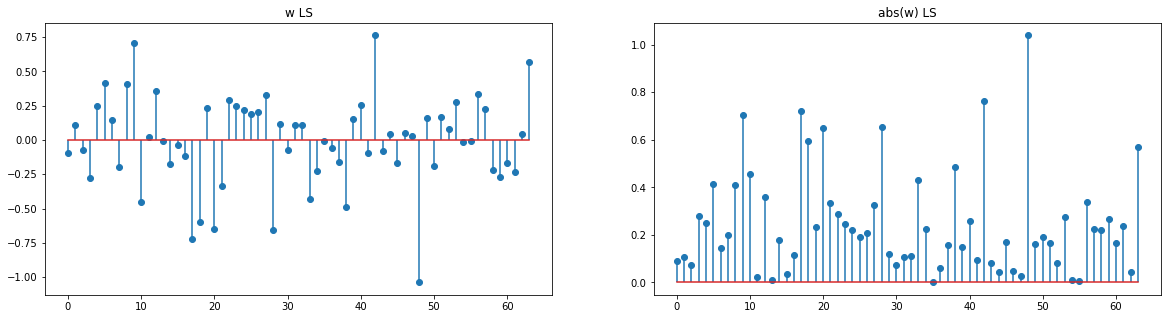

In [52]:
fig, axis = pl.subplots(1,2, figsize=(20,5))
axis[0].stem(reg.coef_[0])
axis[0].set_title('w LS')
axis[1].stem(np.absolute(reg.coef_[0]))
axis[1].set_title('abs(w) LS')

On this graph we can see the importance of each weight W for the regression. We can therefore see the importance of each w and so the importance of each sensor placed on the brain of the subjects. 

In [53]:
sorted_by_importance_variables = [index for index, value in sorted(enumerate(np.absolute(reg.coef_[0])), key=lambda x : x[1],reverse=True)]
sorted_by_importance_variables[:5]

[48, 42, 17, 9, 28]

Here are the 5 most important sensors according to LS. 

Text(0.5, 1.0, 'abs(w) Ridge')

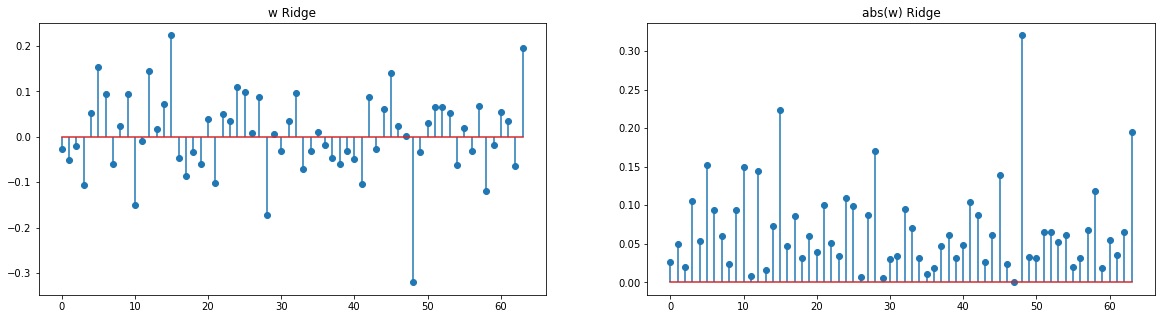

In [54]:
fig, axis = pl.subplots(1,2, figsize=(20,5))
axis[0].stem(ridge.coef_[0])
axis[0].set_title('w Ridge')
axis[1].stem(np.absolute(ridge.coef_[0]))
axis[1].set_title('abs(w) Ridge')

Ridge has reduced the value of the weights compared to LS.

In [55]:
sorted_by_importance_variables = [index for index, value in sorted(enumerate(np.absolute(ridge.coef_[0])), key=lambda x : x[1],reverse=True)]
sorted_by_importance_variables[:5]

[48, 15, 63, 28, 5]

Here are the 5 most important sensors according to Ridge. These are not the same as for LS except for the first one. We can say that the sensor 48 is really important for this problem.  

### 4 - Lasso

Let's do the same for Lasso:

In [56]:
from sklearn.linear_model import Lasso

In [57]:
lasso = Lasso()
lasso.fit(x_train, y_train)

Lasso()

In [58]:
y_train_pred_Lasso = lasso.predict(x_train)
y_test_pred_Lasso = lasso.predict(x_test)

<div class="alert alert-block alert-info">MSE</div>

In [59]:
mse_train_lasso_default = mean_squared_error(y_train, y_train_pred_Lasso)
mse_train_lasso_default

3.1405971577280063

In [60]:
mse_test_lasso_default = mean_squared_error(y_test, y_test_pred_Lasso)
mse_test_lasso_default

2.190675841640482

<div class="alert alert-block alert-info">$R^2$</div>

In [61]:
r2_train_lasso_default = r2_score(y_train, y_train_pred_Lasso)
r2_train_lasso_default

0.0

In [62]:
r2_test_lasso_default = r2_score(y_test, y_test_pred_Lasso)
r2_test_lasso_default

-0.02729265197579034

In [63]:
df = df.append({'Algorithm' : 'Lasso λ Default', 
                
                'MSE Train' : mse_train_lasso_default, 
                'MSE Test' : mse_test_lasso_default,
                
                'R2 Train' : r2_train_lasso_default,
                'R2 Test' : r2_test_lasso_default,
               }, ignore_index=True)
print_measures()

+-----------------+-----------+----------+----------+---------+
|    Algorithm    | MSE Train | MSE Test | R2 Train | R2 Test |
+-----------------+-----------+----------+----------+---------+
|       LS        |    0.5    |   3.05   |   0.84   |  -0.43  |
|      Ridge      |   1.17    |   1.62   |   0.63   |  0.24   |
| Lasso λ Default |   3.14    |   2.19   |   0.0    |  -0.03  |
+-----------------+-----------+----------+----------+---------+


Lasso with default value of Lambda is much less performant than Ridge. 

Let's find best parameters for the Lasso algorithm:

<div class="alert alert-block alert-info">Best Lambda value for Lasso</div>

In [64]:
lambda_values = np.logspace(-3, 2, 100)

In [65]:
obtained_scores_train = []
obtained_scores_test = []
W_lasso = []
for lambda_value in lambda_values:
    clf_test = Lasso(alpha=lambda_value).fit(x_train, y_train)
    obtained_scores_train.append(mean_squared_error(y_train, clf_test.predict(x_train)))
    obtained_scores_test.append(mean_squared_error(y_test, clf_test.predict(x_test)))
    W_lasso.append(clf_test.coef_.ravel())

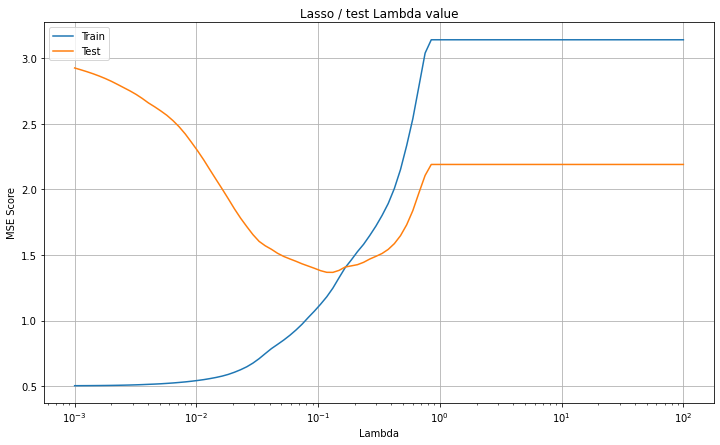

In [66]:
pl.figure(figsize=(12,7))
pl.semilogx(lambda_values,obtained_scores_train, label='Train')
pl.semilogx(lambda_values,obtained_scores_test, label='Test')
pl.ylabel('MSE Score')
pl.xlabel('Lambda')
pl.title('Lasso / test Lambda value')
pl.grid()
pl.legend()

In [67]:
best_lambda_lasso = lambda_values[np.array(obtained_scores_test).argmin()]
best_lambda_lasso

0.13219411484660287

Again, we found the best parameter value for Lasso. Let's now analyze the performance of the algorithm with this value. 

In [68]:
lasso = Lasso(alpha = best_lambda_lasso)
lasso.fit(x_train, y_train)

Lasso(alpha=0.13219411484660287)

In [69]:
y_train_pred_Lasso = lasso.predict(x_train)
y_test_pred_Lasso = lasso.predict(x_test)

<div class="alert alert-block alert-info">Scatter</div>

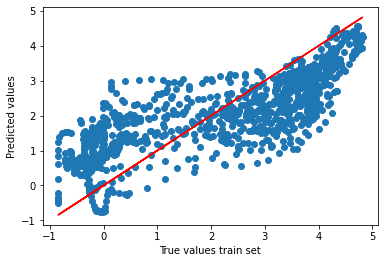

In [70]:
pl.scatter(y_train ,y_train_pred_Lasso)
pl.xlabel('True values train set')
pl.ylabel('Predicted values')
pl.plot(y_train,y_train, c='r')

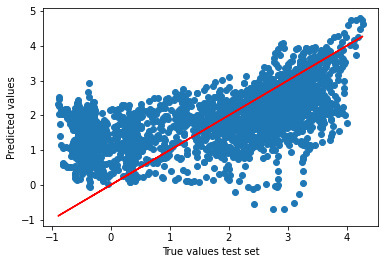

In [71]:
pl.scatter(y_test ,y_test_pred_Lasso)
pl.xlabel('True values test set')
pl.ylabel('Predicted values')
pl.plot(y_test,y_test, c='r')

these two graphs appear to be equal to those of ridge. We will have to look at other graphs to see differences.

<div class="alert alert-block alert-info">BPlot as a function of time</div>

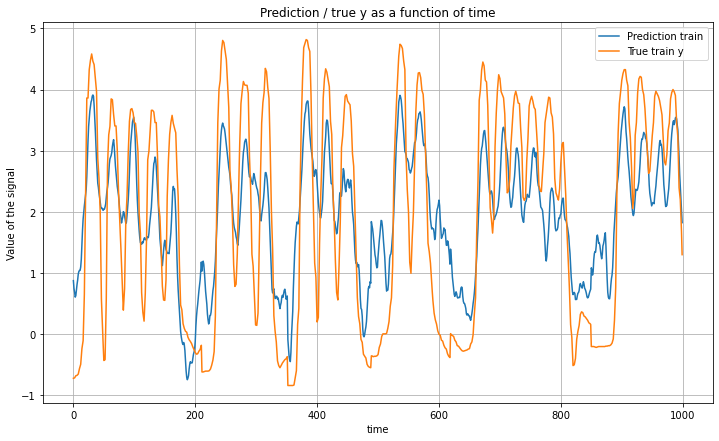

In [72]:
pl.figure(figsize=(12,7))
pl.plot(y_train_pred_Ridge, label='Prediction train')
pl.plot(y_train, label='True train y')
pl.title('Prediction / true y as a function of time')
pl.xlabel('time')
pl.ylabel('Value of the signal')
pl.legend()
pl.grid()

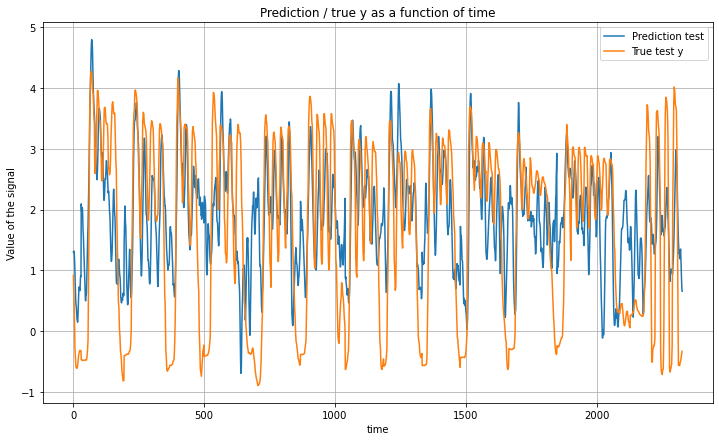

In [73]:
pl.figure(figsize=(12,7))
pl.plot(y_test_pred_Lasso, label='Prediction test')
pl.plot(y_test, label='True test y')
pl.title('Prediction / true y as a function of time')
pl.xlabel('time')
pl.ylabel('Value of the signal')
pl.legend()
pl.grid()

Again, the predictions are very good for the first bending of the finger and less and less good. It's hard to see the differences with Ridge just by looking at this graph. Let's look at the performance measures and analyze w. 

<div class="alert alert-block alert-info">MSE</div>

In [74]:
mse_train_lasso = mean_squared_error(y_train, y_train_pred_Lasso)
mse_train_lasso

1.2485540961935675

In [75]:
mse_test_lasso = mean_squared_error(y_test, y_test_pred_Lasso)
mse_test_lasso

1.3684295299789375

<div class="alert alert-block alert-info">$R^2$</div>

In [76]:
r2_train_lasso = r2_score(y_train, y_train_pred_Lasso)
r2_train_lasso

0.6024469126448533

In [77]:
r2_test_lasso = r2_score(y_test, y_test_pred_Lasso)
r2_test_lasso

0.3582904534879363

In [78]:
df = df.append({'Algorithm' : 'Lasso', 
                
                'MSE Train' : mse_train_lasso, 
                'MSE Test' : mse_test_lasso,
                
                'R2 Train' : r2_train_lasso,
                'R2 Test' : r2_test_lasso,
               }, ignore_index=True)
print_measures()

+-----------------+-----------+----------+----------+---------+
|    Algorithm    | MSE Train | MSE Test | R2 Train | R2 Test |
+-----------------+-----------+----------+----------+---------+
|       LS        |    0.5    |   3.05   |   0.84   |  -0.43  |
|      Ridge      |   1.17    |   1.62   |   0.63   |  0.24   |
| Lasso λ Default |   3.14    |   2.19   |   0.0    |  -0.03  |
|      Lasso      |   1.25    |   1.37   |   0.6    |  0.36   |
+-----------------+-----------+----------+----------+---------+


If we leave the lamba value at default, Lasso is much worse than Ridge. On the other hand if we change the parameter, we gain in performance. The value of the lambda parameter is very important. By applying the right value of lambda we almost go from the worst algorithm on the test data to the best 

for the lambda default, the r2 value on the train data was 0, which means a random prediction. On training data this is really bad. 

<div class="alert alert-block alert-info">Interpret w</div>

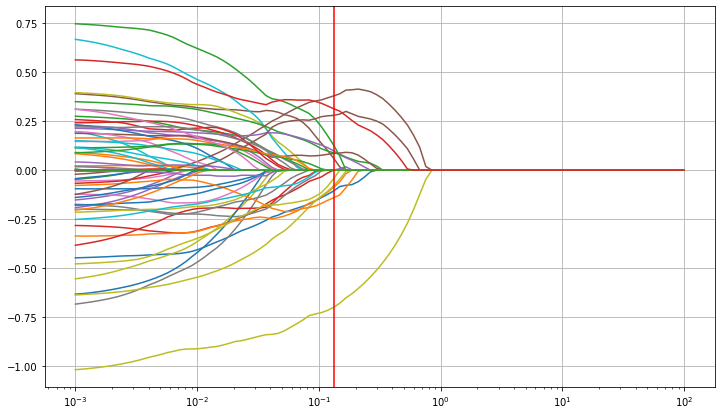

In [79]:
pl.figure(figsize=(12,7))
lambda_values = np.logspace(-3, 2, 100)
fig = pl.semilogx(lambda_values, W_lasso)
pl.axvline(x=best_lambda_lasso,color='r')
pl.grid()

In contrast to Ridge, the weights w are frankly reduced from a certain value of lambda. Lasso allows to make feature reduction. 

Text(0.5, 1.0, 'abs(w) Lasso')

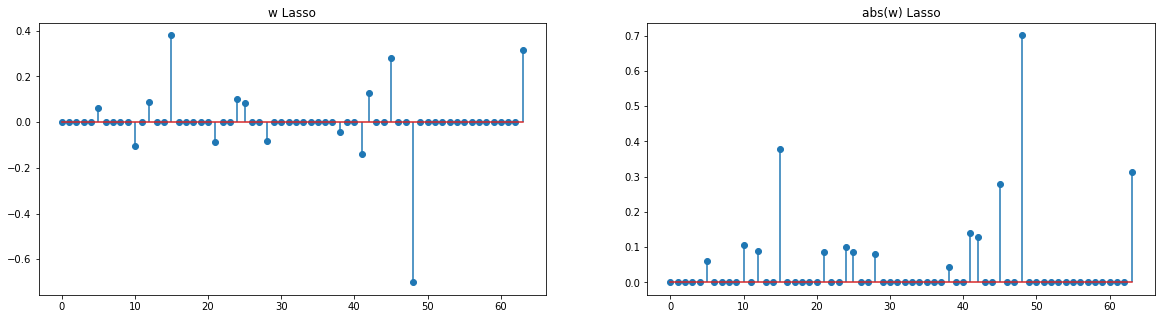

In [80]:
fig, axis = pl.subplots(1,2, figsize=(20,5))
axis[0].stem(lasso.coef_)
axis[0].set_title('w Lasso')
axis[1].stem(np.absolute(lasso.coef_))
axis[1].set_title('abs(w) Lasso')

In [81]:
sorted_by_importance_variables = [index for index, value in sorted(enumerate(np.absolute(lasso.coef_)), key=lambda x : x[1],reverse=True)]
sorted_by_importance_variables[:5]

[48, 15, 63, 45, 41]

On the stem you can see the features that Lasso has kept and those he has removed. The 48 is again the sensor with the most important weight. We can also distinguish one the stem the less important sensors for this regression problem.

All weights equal to 0 are those that Lasso found useless in the prediction of the finger flexion.

<div class="alert alert-block alert-info">Number of features selected by w</div>

In [82]:
np.shape(lasso.coef_)

(64,)

In [83]:
np.count_nonzero(lasso.coef_)

14

Only 14 features were kept out of 64.

it is very interesting in our case. This means that for our problem, we could install only 14 sensors on the patients instead of 64 and get equal or better results. For a patient, the less sensors are installed, the happier he is, but this should not be done in case of a decrease in prediction performance. 

I wanted to go further in this analysis and see if we can reduce a little bit the number of sensors installed without increasing a lot the prediction error:

### Other analysis / Lasso

In [84]:
best_lambda_lasso

0.13219411484660287

In [85]:
best_lambda_range = np.linspace(best_lambda_lasso - 0.01 , best_lambda_lasso + 0.1, 100)

In [86]:
count_sensors = []
MSE_train = []
MSE_test = []
for lambd in best_lambda_range:
    lasso = Lasso(alpha = lambd)
    lasso.fit(x_train, y_train)
    y_train_pred_Lasso = lasso.predict(x_train)
    y_test_pred_Lasso = lasso.predict(x_test)
    MSE_test.append(mean_squared_error(y_test, y_test_pred_Lasso))
    MSE_train.append(mean_squared_error(y_train, y_train_pred_Lasso))
    count_sensors.append(np.count_nonzero(lasso.coef_))

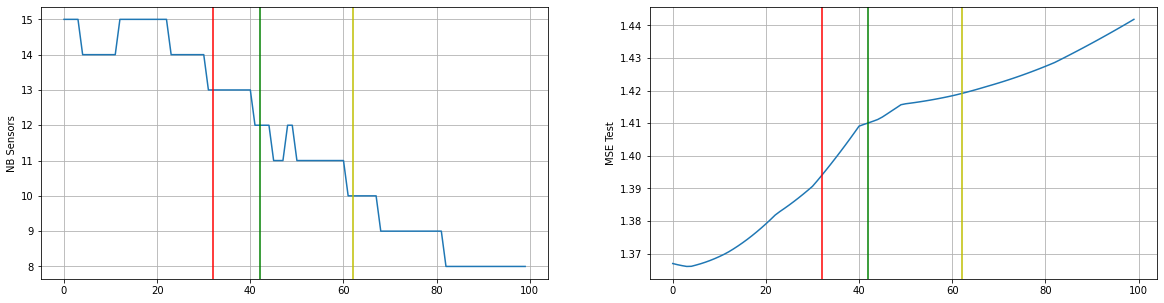

In [87]:
fig, axis = pl.subplots(1,2, figsize=(20,5))
axis[0].plot(count_sensors)
axis[0].grid()
axis[0].axvline(x=32,color='r')
axis[0].axvline(x=42,color='g')
axis[0].axvline(x=62,color='y')
axis[0].set_ylabel('NB Sensors')
axis[1].plot(MSE_test)
axis[1].axvline(x=32,color='r')
axis[1].axvline(x=42,color='g')
axis[1].axvline(x=62,color='y')
axis[1].set_ylabel('MSE Test')
axis[1].grid()

- 14 sensors on patient / MSE = 1.37 
- 13 sensors on patient / MSE = 1.39 / red line
- 12 sensors on patient / MSE = 1.41 / green line
- 10 sensors on patient / MSE = 1.42 / yellow line

This shows that if we accept to increase a little the prediction error, we can still reduce the number of sensors on the patient. From 14 sensors to 10, we only increase the MSE by 0.05.

### 4 - Nonlinear regression

In [88]:
def compute_measures(clf, df,algorithm_name_for_df_save=''):
    y_train_pred = clf.predict(x_train)
    y_test_pred  = clf.predict(x_test)
    print('MSE')
    print('----------------')
    print('Train ', round(mean_squared_error(y_train, y_train_pred), 2))
    print('Test ', round(mean_squared_error(y_test, y_test_pred), 2))
    print()
    print('R2')
    print('----------------')
    print('Train ', round(r2_score(y_train, y_train_pred), 2))
    print('Test ',round(r2_score(y_test, y_test_pred), 2))
    
    if len(algorithm_name_for_df_save) > 0:
        df = df.append({'Algorithm' : algorithm_name_for_df_save, 
                
                'MSE Train' : mean_squared_error(y_train, y_train_pred), 
                'MSE Test' : mean_squared_error(y_test, y_test_pred),
                
                'R2 Train' : r2_score(y_train, y_train_pred),
                'R2 Test' : r2_score(y_test, y_test_pred),
               }, ignore_index=True)
        return df

<div class="alert alert-block alert-info">RandomForestRegressor</div>

In [89]:
from sklearn.ensemble import RandomForestRegressor

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html

In [90]:
random_forest_regressor = RandomForestRegressor()

In [91]:
random_forest_regressor.fit(x_train, y_train.ravel())

RandomForestRegressor()

In [92]:
df = compute_measures(random_forest_regressor,df ,'RandomForest Default')

MSE
----------------
Train  0.02
Test  1.67

R2
----------------
Train  0.99
Test  0.22


The model is very good on the train data but bad on the test data. It seems to overfit. 

#### n_estimators

In [93]:
n_estimators_list = [i for i in range(20, 100,10)]
n_estimators_list

[20, 30, 40, 50, 60, 70, 80, 90]

In [94]:
obtained_scores_train = []
obtained_scores_test  = []
for n_estimators in n_estimators_list:
    random_forest_regressor = RandomForestRegressor(n_estimators=n_estimators)
    random_forest_regressor.fit(x_train, y_train.ravel())
    
    obtained_scores_train.append(mean_squared_error(y_train, random_forest_regressor.predict(x_train)))
    obtained_scores_test.append(mean_squared_error(y_test, random_forest_regressor.predict(x_test)))

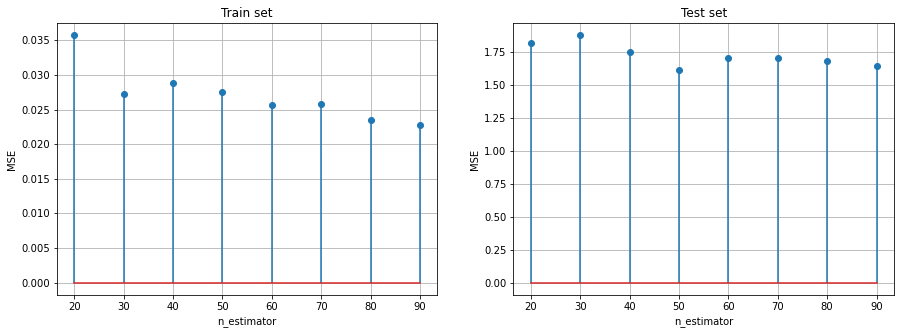

In [95]:
figure, axis = pl.subplots(1,2,figsize=(15,5))
axis[0].stem(n_estimators_list, obtained_scores_train)
axis[0].set_title('Train set')
axis[0].set_xlabel('n_estimator')
axis[0].set_ylabel('MSE')
axis[0].grid()

axis[1].stem(n_estimators_list, obtained_scores_test)
axis[1].set_title('Test set')
axis[1].set_xlabel('n_estimator')
axis[1].set_ylabel('MSE')
axis[1].grid()

In [96]:
best_parameter_n_estimators = n_estimators_list[np.array(obtained_scores_test).argmin()]
best_parameter_n_estimators

50

#### max_features

In [97]:
max_features_list = [i for i in range(10, 50,5)]
max_features_list

[10, 15, 20, 25, 30, 35, 40, 45]

In [98]:
obtained_scores_train = []
obtained_scores_test  = []
for max_features in max_features_list:
    random_forest_regressor = RandomForestRegressor(n_estimators=best_parameter_n_estimators,max_features=max_features)
    random_forest_regressor.fit(x_train, y_train.ravel())
    
    obtained_scores_train.append(mean_squared_error(y_train, random_forest_regressor.predict(x_train)))
    obtained_scores_test.append(mean_squared_error(y_test, random_forest_regressor.predict(x_test)))

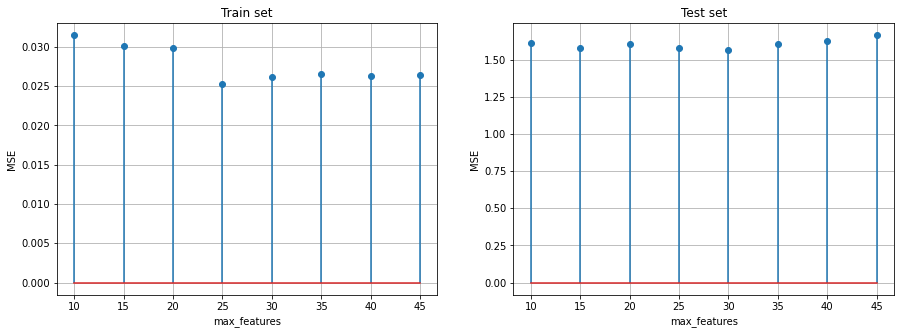

In [99]:
figure, axis = pl.subplots(1,2,figsize=(15,5))
axis[0].stem(max_features_list, obtained_scores_train)
axis[0].set_title('Train set')
axis[0].set_xlabel('max_features')
axis[0].set_ylabel('MSE')
axis[0].grid()

axis[1].stem(max_features_list, obtained_scores_test)
axis[1].set_title('Test set')
axis[1].set_xlabel('max_features')
axis[1].set_ylabel('MSE')
axis[1].grid()

In [100]:
best_parameter_max_features = max_features_list[np.array(obtained_scores_test).argmin()]
best_parameter_max_features

30

In [150]:
random_forest_regressor = RandomForestRegressor(n_estimators=best_parameter_n_estimators, max_features=best_parameter_max_features)
random_forest_regressor.fit(x_train, y_train.ravel())
df = compute_measures(random_forest_regressor,df ,'RandomForest')

MSE
----------------
Train  0.03
Test  1.6

R2
----------------
Train  0.99
Test  0.25


this model seems not to be adapted to our case. In my opinion Random forest is very good in models where the test data are close to the train data. Our case is more complicated, it requires the algorithm to adapt more. 

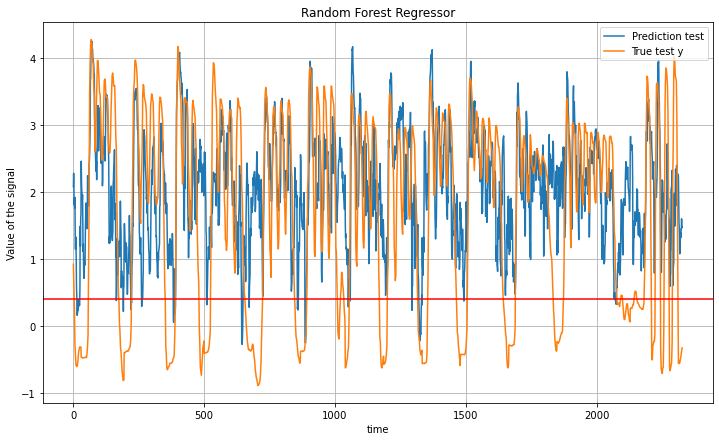

In [102]:
pl.figure(figsize=(12,7))
pl.plot(random_forest_regressor.predict(x_test), label='Prediction test')
pl.plot(y_test, label='True test y')
pl.title('')
pl.xlabel('time')
pl.ylabel('Value of the signal')
pl.title('Random Forest Regressor')
pl.axhline(y=0.4, c='r')
pl.legend()
pl.grid()

The two curves do not seem equal at all. However we can predict when the finger will be bent thanks to the predictive curve. When the predictive curve crosses over the red curve, we can predict a bending. 

In [103]:
random_forest_regressor = RandomForestRegressor(n_estimators=best_parameter_n_estimators, max_depth=50)
random_forest_regressor.fit(x_train, y_train.ravel())

RandomForestRegressor(max_depth=50, n_estimators=50)

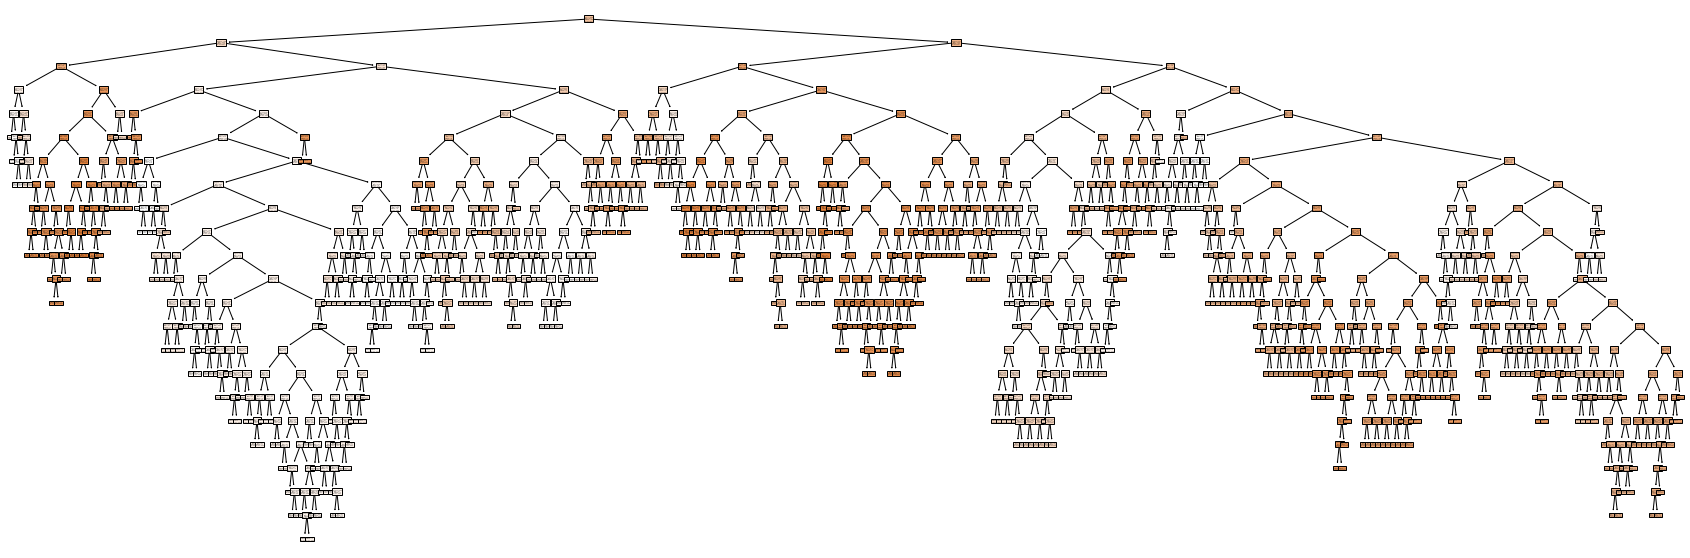

In [104]:
from sklearn import tree
figure, axis = pl.subplots(1,figsize=(30,10))
_ = tree.plot_tree(random_forest_regressor.estimators_[0], filled=True)

Thanks to this algorithm we can draw the decision tree. There is too much depth here, we can't see anything. 

In [105]:
random_forest_regressor = RandomForestRegressor(n_estimators=best_parameter_n_estimators, max_depth=3)
random_forest_regressor.fit(x_train, y_train.ravel())

RandomForestRegressor(max_depth=3, n_estimators=50)

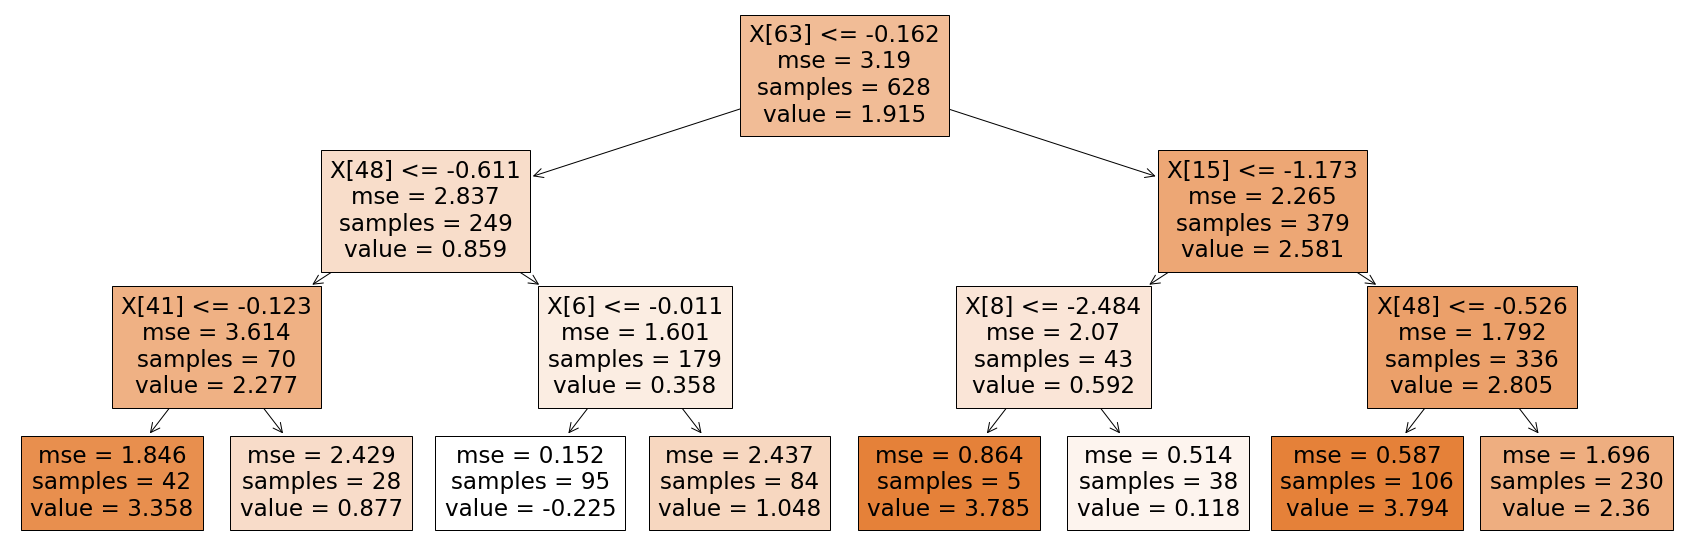

In [106]:
figure, axis = pl.subplots(1,figsize=(30,10))
_ = tree.plot_tree(random_forest_regressor.estimators_[0], filled=True)

if we reduce the max_depth to 3, we can see that the first element of choice for the algorithm is 48. Again this sensor is very important. The random forest can be very interesting to visualize the classification or regression, this is not our case for this dataset.

<div class="alert alert-block alert-info">SVR</div>

In [107]:
from sklearn.svm import SVR

In [108]:
svr = SVR()

In [109]:
svr.fit(x_train, y_train.ravel())

SVR()

In [110]:
df = compute_measures(svr, df, 'SVR Default')

MSE
----------------
Train  0.02
Test  1.52

R2
----------------
Train  0.99
Test  0.29


### C : Regularization parameter

In [111]:
C =  np.logspace(-1,1,100)

In [112]:
obtained_scores_train = []
obtained_scores_test  = []
for c in C:
    svr = SVR(C=c)
    svr.fit(x_train, y_train.ravel())
    
    obtained_scores_train.append(mean_squared_error(y_train, svr.predict(x_train)))
    obtained_scores_test.append(mean_squared_error(y_test, svr.predict(x_test)))

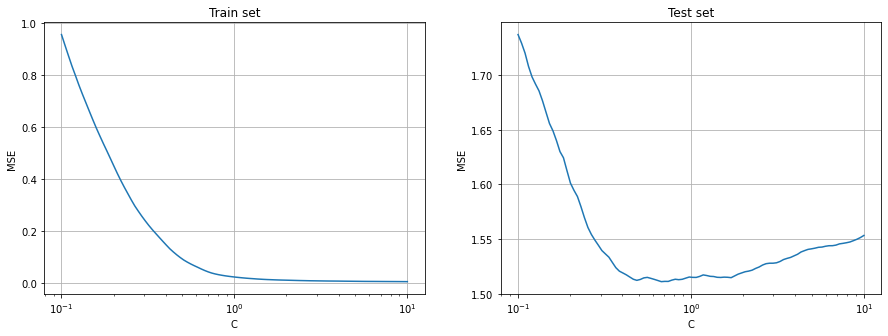

In [113]:
figure, axis = pl.subplots(1,2,figsize=(15,5))
axis[0].semilogx(C, obtained_scores_train)
axis[0].set_title('Train set')
axis[0].set_xlabel('C')
axis[0].set_ylabel('MSE')
axis[0].grid()

axis[1].semilogx(C, obtained_scores_test)
axis[1].set_title('Test set')
axis[1].set_xlabel('C')
axis[1].set_ylabel('MSE')
axis[1].grid()

In [114]:
best_parameter_C = C[np.argmin(obtained_scores_test)]
best_parameter_C

0.6734150657750824

### epsilon

In [115]:
epsilon = np.logspace(-4,-1,100)

In [116]:
obtained_scores_train = []
obtained_scores_test  = []
for eps in epsilon:
    svr = SVR(epsilon=eps, C=best_parameter_C)
    svr.fit(x_train, y_train.ravel())
    
    obtained_scores_train.append(mean_squared_error(y_train, svr.predict(x_train)))
    obtained_scores_test.append(mean_squared_error(y_test, svr.predict(x_test)))

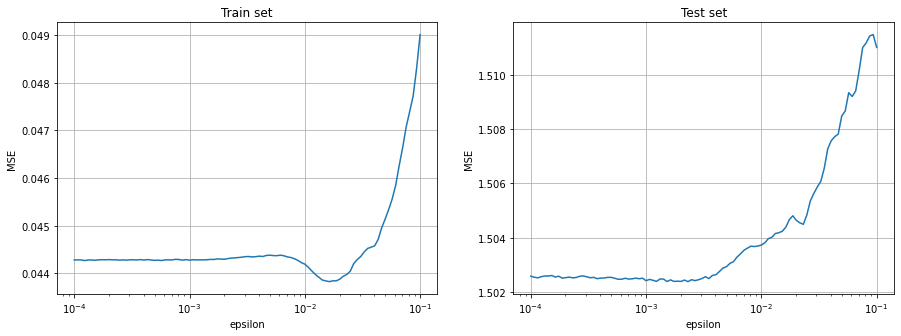

In [117]:
figure, axis = pl.subplots(1,2,figsize=(15,5))
axis[0].semilogx(epsilon, obtained_scores_train)
axis[0].set_title('Train set')
axis[0].set_xlabel('epsilon')
axis[0].set_ylabel('MSE')
axis[0].grid()

axis[1].semilogx(epsilon, obtained_scores_test)
axis[1].set_title('Test set')
axis[1].set_xlabel('epsilon')
axis[1].set_ylabel('MSE')
axis[1].grid()

In [118]:
best_parameter_epsilon = epsilon[np.argmin(obtained_scores_test)]
best_parameter_epsilon 

0.0023101297000831605

In [119]:
svr = SVR(C=best_parameter_C, epsilon=best_parameter_epsilon)
svr.fit(x_train, y_train.ravel())

SVR(C=0.6734150657750824, epsilon=0.0023101297000831605)

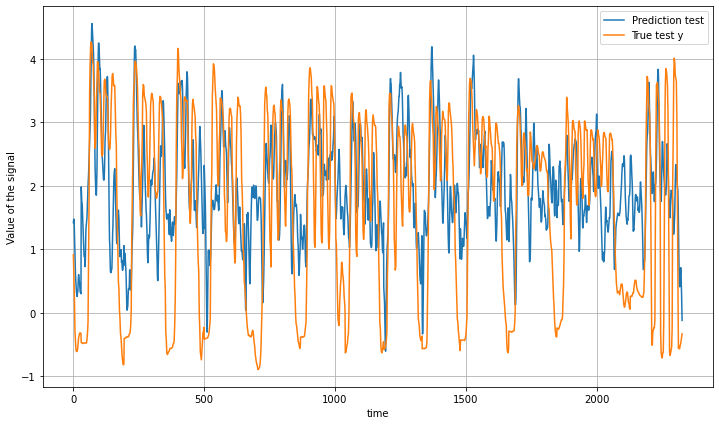

In [120]:
pl.figure(figsize=(12,7))
pl.plot(svr.predict(x_test), label='Prediction test')
pl.plot(y_test, label='True test y')
pl.title('')
pl.xlabel('time')
pl.ylabel('Value of the signal')
pl.legend()
pl.grid()

In [121]:
df = compute_measures(svr, df, 'SVR')

MSE
----------------
Train  0.04
Test  1.5

R2
----------------
Train  0.99
Test  0.3


<div class="alert alert-block alert-info">MLP regressor</div>

In [122]:
from sklearn.neural_network import MLPRegressor

In [123]:
mlp_regressor = MLPRegressor()

In [124]:
mlp_regressor.fit(x_train, y_train.ravel())

MLPRegressor()

In [125]:
df = compute_measures(mlp_regressor, df,'MLPRegressor Default')

MSE
----------------
Train  0.01
Test  2.36

R2
----------------
Train  1.0
Test  -0.1


The model is too good on the train data and not good enough on the test data. It is overfitting.

### alpha : L2 penalty (regularization term) parameter.

In [126]:
ALPHA = np.linspace(0.0001, 0.0002, 50)

In [127]:
obtained_scores_train = []
obtained_scores_test  = []
for alpha in ALPHA:
    lp_regressor = MLPRegressor(alpha=alpha)
    mlp_regressor.fit(x_train, y_train.ravel())
    
    obtained_scores_train.append(mean_squared_error(y_train, mlp_regressor.predict(x_train)))
    obtained_scores_test.append(mean_squared_error(y_test, mlp_regressor.predict(x_test)))

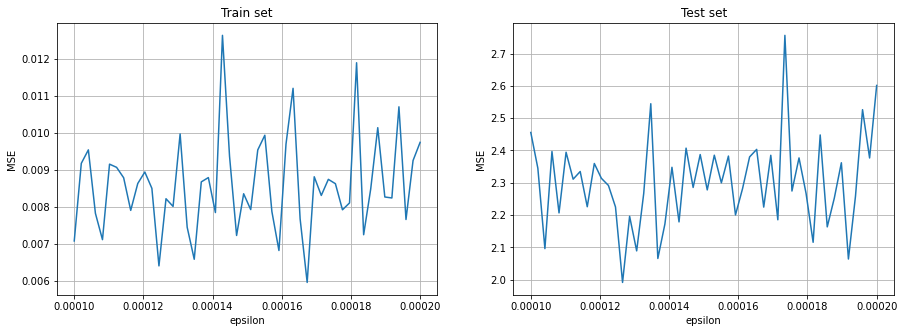

In [128]:
figure, axis = pl.subplots(1,2,figsize=(15,5))
axis[0].plot(ALPHA, obtained_scores_train)
axis[0].set_title('Train set')
axis[0].set_xlabel('epsilon')
axis[0].set_ylabel('MSE')
axis[0].grid()

axis[1].plot(ALPHA, obtained_scores_test)
axis[1].set_title('Test set')
axis[1].set_xlabel('epsilon')
axis[1].set_ylabel('MSE')
axis[1].grid()

In [129]:
alpha = ALPHA[np.argmin(obtained_scores_test)]
alpha

0.00012653061224489798

In [130]:
lp_regressor = MLPRegressor(alpha=alpha)
mlp_regressor.fit(x_train, y_train.ravel())

MLPRegressor()

In [131]:
df = compute_measures(mlp_regressor, df,'MLPRegressor')

MSE
----------------
Train  0.01
Test  2.19

R2
----------------
Train  1.0
Test  -0.03


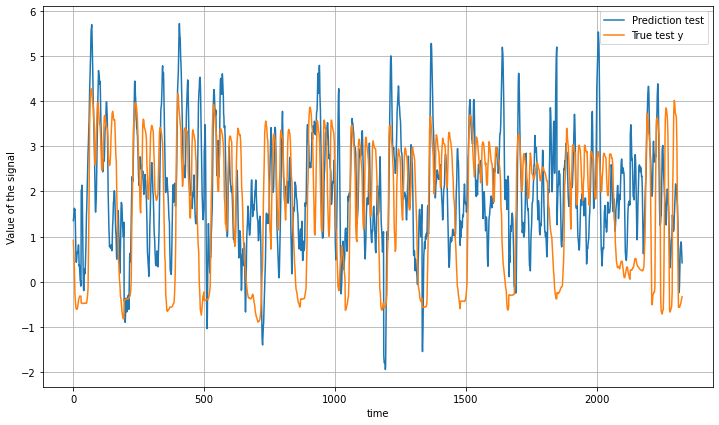

In [132]:
pl.figure(figsize=(12,7))
pl.plot(mlp_regressor.predict(x_test), label='Prediction test')
pl.plot(y_test, label='True test y')
pl.title('')
pl.xlabel('time')
pl.ylabel('Value of the signal')
pl.legend()
pl.grid()

<div class="alert alert-block alert-info">GradientBoostingRegressor</div>

In [133]:
from sklearn.ensemble import GradientBoostingRegressor

In [134]:
gradient_boosting_regressor = GradientBoostingRegressor()

In [135]:
gradient_boosting_regressor.fit(x_train, y_train.ravel())

GradientBoostingRegressor()

In [136]:
df = compute_measures(gradient_boosting_regressor, df,'GradientBoostingRegressor Default')

MSE
----------------
Train  0.11
Test  1.68

R2
----------------
Train  0.96
Test  0.21


In [137]:
n_estimators_list = [i for i in range(10, 200,10)]

In [138]:
obtained_scores_train = []
obtained_scores_test  = []
for n_estimators in n_estimators_list:
    gradient_boosting_regressor = GradientBoostingRegressor(n_estimators=n_estimators)
    gradient_boosting_regressor.fit(x_train, y_train.ravel())
    
    obtained_scores_train.append(mean_squared_error(y_train, gradient_boosting_regressor.predict(x_train)))
    obtained_scores_test.append(mean_squared_error(y_test, gradient_boosting_regressor.predict(x_test)))

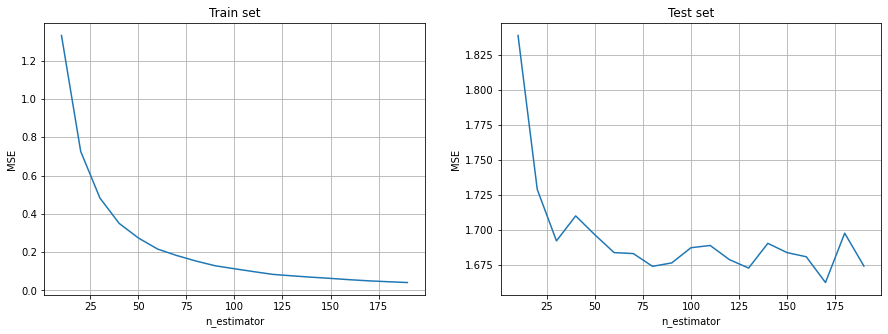

In [139]:
figure, axis = pl.subplots(1,2,figsize=(15,5))
axis[0].plot(n_estimators_list, obtained_scores_train)
axis[0].set_title('Train set')
axis[0].set_xlabel('n_estimator')
axis[0].set_ylabel('MSE')
axis[0].grid()

axis[1].plot(n_estimators_list, obtained_scores_test)
axis[1].set_title('Test set')
axis[1].set_xlabel('n_estimator')
axis[1].set_ylabel('MSE')
axis[1].grid()

In [140]:
best_parameter = n_estimators_list[np.array(obtained_scores_test).argmin()]
best_parameter

170

In [141]:
learning_rate = np.linspace(0.001, 0.2, 25)

In [142]:
obtained_scores_train = []
obtained_scores_test  = []
for lr in learning_rate:
    gradient_boosting_regressor = GradientBoostingRegressor(learning_rate=lr)
    gradient_boosting_regressor.fit(x_train, y_train.ravel())
    
    obtained_scores_train.append(mean_squared_error(y_train, gradient_boosting_regressor.predict(x_train)))
    obtained_scores_test.append(mean_squared_error(y_test, gradient_boosting_regressor.predict(x_test)))

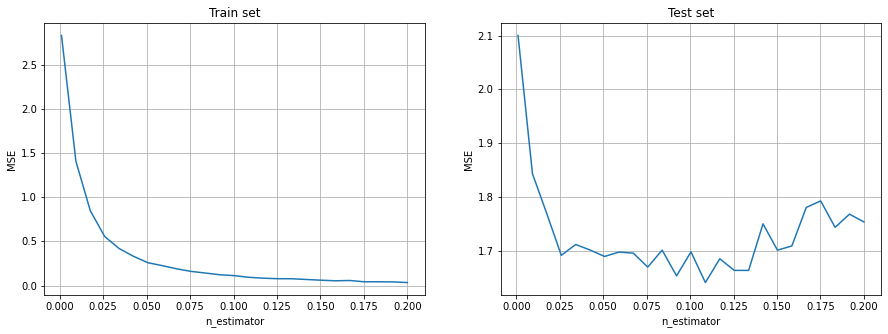

In [143]:
figure, axis = pl.subplots(1,2,figsize=(15,5))
axis[0].plot(learning_rate, obtained_scores_train)
axis[0].set_title('Train set')
axis[0].set_xlabel('n_estimator')
axis[0].set_ylabel('MSE')
axis[0].grid()

axis[1].plot(learning_rate, obtained_scores_test)
axis[1].set_title('Test set')
axis[1].set_xlabel('n_estimator')
axis[1].set_ylabel('MSE')
axis[1].grid()

In [144]:
lr = learning_rate[np.argmin(obtained_scores_test)]
lr

0.10879166666666668

In [145]:
gradient_boosting_regressor = GradientBoostingRegressor(n_estimators=best_parameter, learning_rate=lr)

In [146]:
gradient_boosting_regressor.fit(x_train, y_train.ravel())

GradientBoostingRegressor(learning_rate=0.10879166666666668, n_estimators=170)

In [147]:
df = compute_measures(gradient_boosting_regressor, df,'GradientBoostingRegressor')

MSE
----------------
Train  0.04
Test  1.64

R2
----------------
Train  0.99
Test  0.23


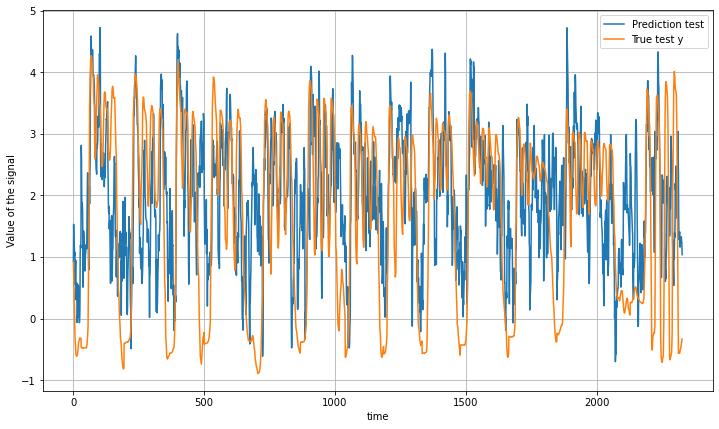

In [148]:
pl.figure(figsize=(12,7))
pl.plot(gradient_boosting_regressor.predict(x_test), label='Prediction test')
pl.plot(y_test, label='True test y')
pl.title('')
pl.xlabel('time')
pl.ylabel('Value of the signal')
pl.legend()
pl.grid()

### 7 - Final comparison of the performances

In [151]:
print_measures()

+-----------------------------------+-----------+----------+----------+---------+
|             Algorithm             | MSE Train | MSE Test | R2 Train | R2 Test |
+-----------------------------------+-----------+----------+----------+---------+
|                LS                 |    0.5    |   3.05   |   0.84   |  -0.43  |
|               Ridge               |   1.17    |   1.62   |   0.63   |  0.24   |
|          Lasso λ Default          |   3.14    |   2.19   |   0.0    |  -0.03  |
|               Lasso               |   1.25    |   1.37   |   0.6    |  0.36   |
|       RandomForest Default        |   0.02    |   1.67   |   0.99   |  0.22   |
|            SVR Default            |   0.02    |   1.52   |   0.99   |  0.29   |
|                SVR                |   0.04    |   1.5    |   0.99   |   0.3   |
|       MLPRegressor Default        |   0.01    |   2.36   |   1.0    |  -0.1   |
|           MLPRegressor            |   0.01    |   2.19   |   1.0    |  -0.03  |
| GradientBoosti

 Collect the test performances for all methods investigated above in a table (in a dataframe and printing it for instance). Which methods work the best in practice?
 
- What are the most interpretable models?
- Which model is best from a medical/practical perspective?
- Do we need non-linearity in this application?
- Is validation on the test data a good practice? What would you do if you need to provide a model to a client for prediction in production?